In [ ]:
pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from typing import Callable

## Tool

In [66]:
def plot_feature_importance(importance,names,model_type, num_best=None):
    if num_best is None:
      num_best = len(importance)
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df = (
        fi_df.sort_values(by=['feature_importance'], ascending=False)
        .head(num_best)
    )
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [67]:
def compare_lists(a, b):
  if collections.Counter(a) == collections.Counter(b):
    return True
  return False

In [68]:
def encode_categorical_features(train, test):
  categorical_cols = train.select_dtypes('object').columns.tolist()
  
  train = pd.get_dummies(train, columns=categorical_cols)
  test  = pd.get_dummies(test, columns=categorical_cols)
  return train, test

In [71]:
def concept_drift_check(
    train_df, test_df, target_col=None, 
    plot_fi_diagram=False, plot_roc_auc=False, seed=42, 
    n_folds=5, early_stopping_rounds=10, iterations=5000, num_best=5):
  if target_col is not None:
    if target_col not in train_df.columns:
      raise KeyError('Column {0} is not in train_df.columns'.format(target_col))
    train_df.drop(target_col, axis=1, inplace=True)
  
  if not compare_lists(train_df.columns, test_df.columns):
    raise NameError('Found difference in train_df.columns and test_df.columns')

  train_df, test_df = encode_categorical_features(train_df, test_df)
  
  train_df['is_train'] = 1
  test_df['is_train'] = 0

  X = pd.concat([train_df, test_df], axis=0)
  y = X['is_train']
  X.drop('is_train', axis=1, inplace=True)

  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

  params = {
        'eval_metric': 'AUC',
        'learning_rate' : 0.05,
        'iterations': iterations,
    }

  cat = CatBoostClassifier(**params, random_seed=seed)

  scores = []

  for fold, (train_id, test_id) in enumerate(skf.split(X, y)):
    print('=' * 10)
    print('Processing for Fold no. ', fold)

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]

    print('X_train.shape : ', X_train.shape)

    cat.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=early_stopping_rounds
    )

    valid_pred = cat.predict_proba(X_valid)[:, 1]
    valid_score = roc_auc_score(y_valid, valid_pred)
    scores.append(valid_score)
    print('ROC_AUC score: ', valid_score)

  if plot_fi_diagram:
    cat.fit(
      X_train, y_train,
      verbose=False,
      early_stopping_rounds=early_stopping_rounds
    )
    plot_feature_importance(
        importance=cat.get_feature_importance(),
        names=X.columns, 
        model_type='CatBoostClassifier',
        num_best=num_best
    )
    plt.show()

  if plot_roc_auc:
    plt.figure(figsize=(10,8))
    plt.plot(scores)
    plt.ylim([0.0, 1.0])
    plt.title('CatBoostClassifier ROC_AUC on CV')
    plt.show()

  return np.mean(scores)

## California Housing Dataset

Ниже можно найти пример применения для California Housing Dataset

Processing for Fold no.  0
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5042303921568627
Processing for Fold no.  1
X_train.shape :  (16000, 8)
ROC_AUC score:  0.529925
Processing for Fold no.  2
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5091323529411764
Processing for Fold no.  3
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5245524509803922
Processing for Fold no.  4
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5155458333333334


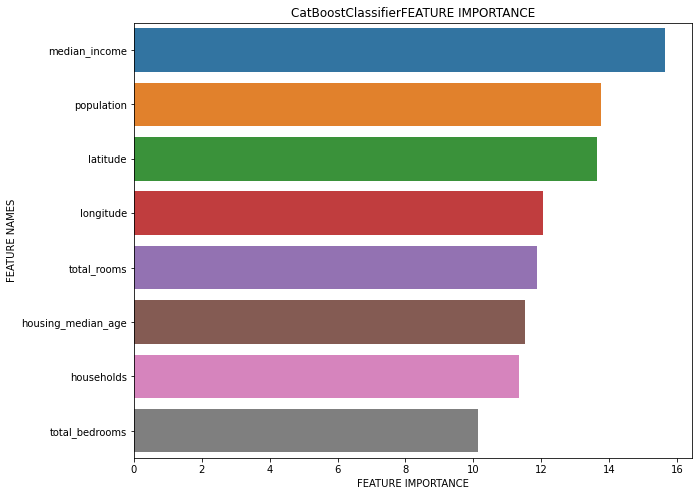

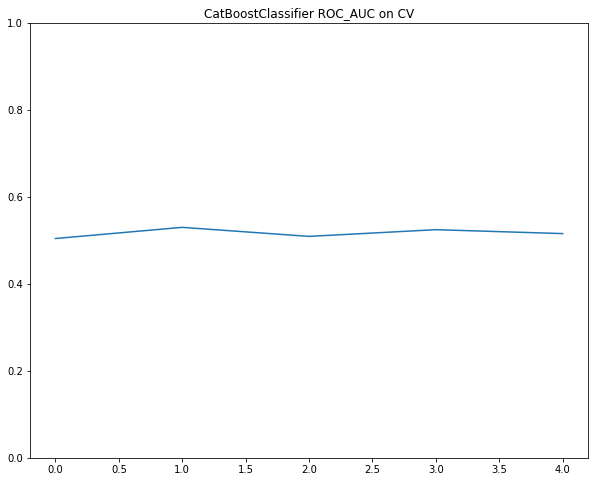

In [ ]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test = pd.read_csv('/content/sample_data/california_housing_test.csv')

train.drop(columns=['median_house_value'], axis=1, inplace=True)
test.drop(columns=['median_house_value'], axis=1, inplace=True)

mean_score = concept_drift_check(train, test, plot_fi_diagram=True, plot_roc_auc=True, iterations=2000)

## TP_Jan_2022 dataset

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [11]:
!kaggle competitions download -c tabular-playground-series-jan-2022

  0% 0.00/186k [00:00<?, ?B/s]
100% 186k/186k [00:00<00:00, 69.5MB/s]
  0% 0.00/306k [00:00<?, ?B/s]
100% 306k/306k [00:00<00:00, 57.5MB/s]
  0% 0.00/64.2k [00:00<?, ?B/s]
100% 64.2k/64.2k [00:00<00:00, 69.7MB/s]


In [12]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [37]:
train_r = train.drop(columns=['row_id', 'date'])
test_r = test.drop(columns=['row_id', 'date'])

In [38]:
train_r.columns

Index(['country', 'store', 'product', 'num_sold'], dtype='object')

Processing for Fold no.  0
X_train.shape :  (26294, 8)
ROC_AUC score:  0.4729062132865717
Processing for Fold no.  1
X_train.shape :  (26294, 8)
ROC_AUC score:  0.47036839302972955
Processing for Fold no.  2
X_train.shape :  (26294, 8)
ROC_AUC score:  0.4758364150910638
Processing for Fold no.  3
X_train.shape :  (26295, 8)
ROC_AUC score:  0.4669472901857308
Processing for Fold no.  4
X_train.shape :  (26295, 8)
ROC_AUC score:  0.4752061624878479


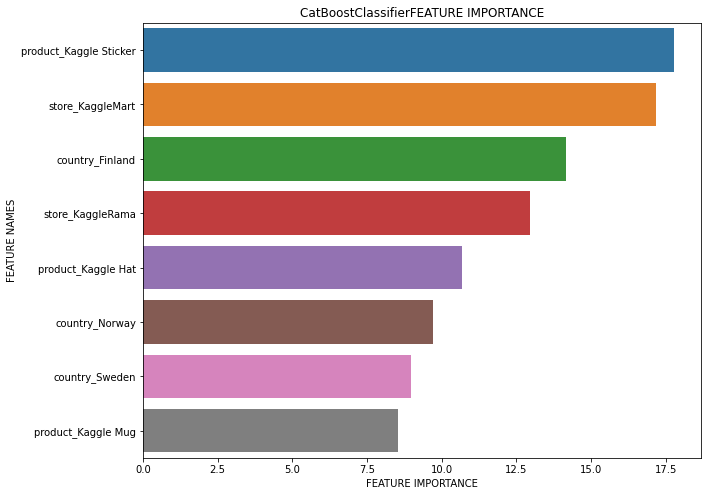

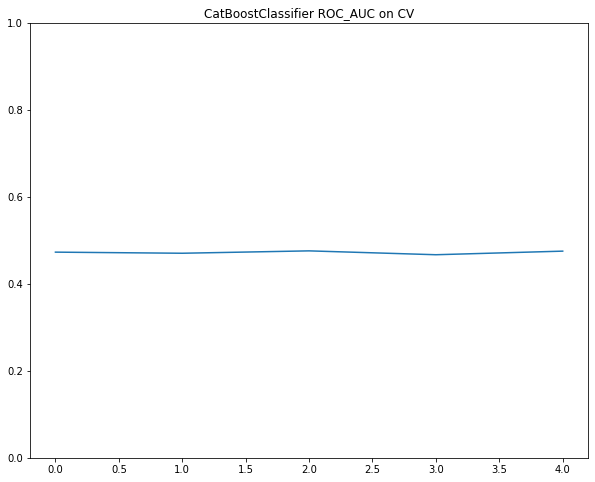

0.4722528948161887

In [39]:
concept_drift_check(
    train_df=train_r, 
    test_df=test_r, 
    target_col='num_sold', 
    plot_fi_diagram=True,
    plot_roc_auc=True)

In [30]:
categorical_cols = train_r.select_dtypes('object').columns.tolist()

In [35]:
train_r.columns

Index(['country', 'store', 'product', 'is_train'], dtype='object')

## Sberbank Russian Housing Countries

In [54]:
!unzip sberbank-russian-housing-market.zip

Archive:  sberbank-russian-housing-market.zip
  inflating: data_dictionary.txt     
  inflating: macro.csv.zip           
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [60]:
!unzip train.csv.zip 

Archive:  train.csv.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    


In [61]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Processing for Fold no.  0
X_train.shape :  (30506, 451)
ROC_AUC score:  1.0
Processing for Fold no.  1
X_train.shape :  (30506, 451)
ROC_AUC score:  1.0
Processing for Fold no.  2
X_train.shape :  (30506, 451)
ROC_AUC score:  1.0
Processing for Fold no.  3
X_train.shape :  (30507, 451)
ROC_AUC score:  1.0
Processing for Fold no.  4
X_train.shape :  (30507, 451)
ROC_AUC score:  1.0


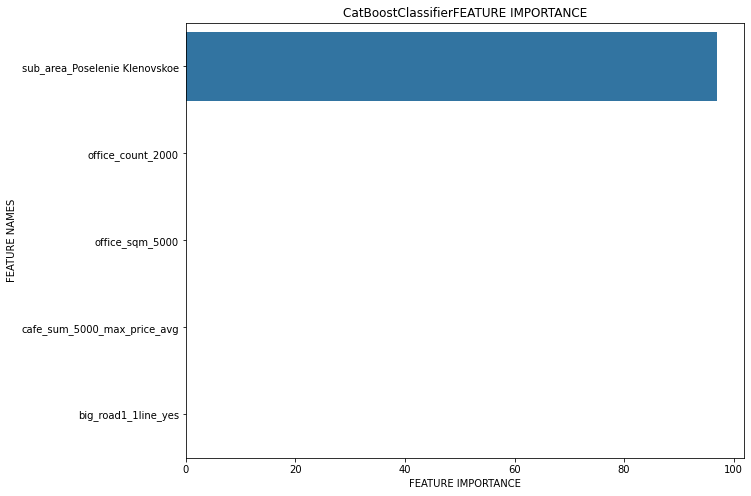

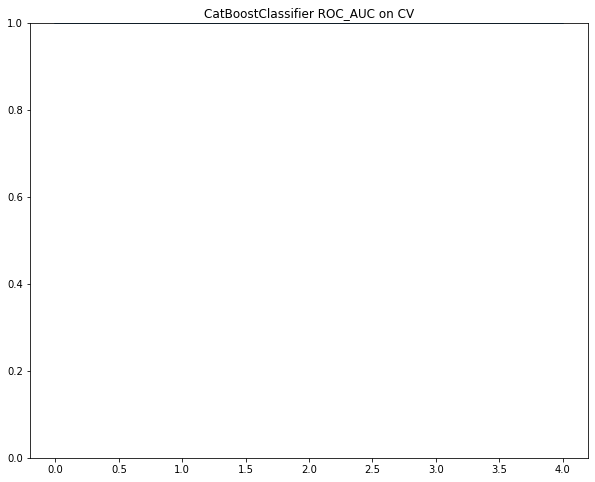

1.0

In [93]:
train_r = train.drop(columns=['id', 'timestamp'])
test_r = test.drop(columns=['id', 'timestamp'])

concept_drift_check(
    train_r,
    test_r,
    'price_doc',
    plot_fi_diagram=True,
    plot_roc_auc=True
    )

Почти весь FE находится в признаке sub_area_Poselenie... удалим объекты с этим значением sub_area из обучения и посмотрим, стало ли получше

Processing for Fold no.  0
X_train.shape :  (30505, 450)
ROC_AUC score:  0.9836513238669413
Processing for Fold no.  1
X_train.shape :  (30505, 450)
ROC_AUC score:  0.9684762058902803
Processing for Fold no.  2
X_train.shape :  (30506, 450)
ROC_AUC score:  0.9860983945172282
Processing for Fold no.  3
X_train.shape :  (30506, 450)
ROC_AUC score:  0.9785276533610511
Processing for Fold no.  4
X_train.shape :  (30506, 450)
ROC_AUC score:  0.9913531565097203


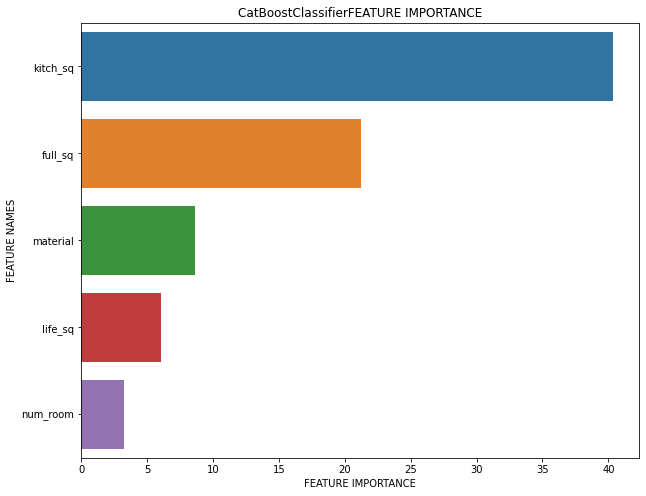

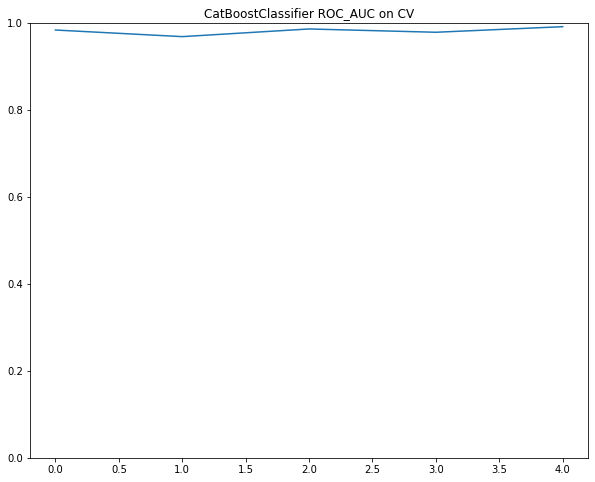

0.9816213468290442

In [94]:
train_r = train.drop(columns=['id', 'timestamp'])
train_r.drop(
    train_r[train_r['sub_area'] == 'Poselenie Klenovskoe'].index,
    inplace=True)
test_r = test.drop(columns=['id', 'timestamp'])

concept_drift_check(
    train_r,
    test_r,
    'price_doc',
    plot_fi_diagram=True,
    plot_roc_auc=True
    )